In [71]:
%matplotlib inline

import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.datasets import load_breast_cancer, load_boston

from sklearn.ensemble import GradientBoostingClassifier

from sklearn import preprocessing
from sklearn import utils


# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import itertools


In [72]:
d = pd.read_csv('data/cleaned_data_together.csv')

In [73]:
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

In [74]:
df = df_cleaner(d)

In [75]:
df.head()

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2
2,2010-01-03,5.82,23.5537,2197157.0,3117.0,255035.0,1666520.0,3
3,2010-01-04,6.09,23.2831,2197157.0,3117.0,255035.0,1666520.0,4
4,2010-01-05,6.19,24.5469,2197157.0,3117.0,255035.0,1666520.0,5


In [76]:
def dow(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.timetuple().tm_wday

In [77]:
df['DOW'] =df['DateTime']

In [78]:
df['DOW'] = df['DOW'].apply(lambda x : dow(x))

In [79]:
df.head(5)

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,DOW
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,4
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,5
2,2010-01-03,5.82,23.5537,2197157.0,3117.0,255035.0,1666520.0,3,6
3,2010-01-04,6.09,23.2831,2197157.0,3117.0,255035.0,1666520.0,4,0
4,2010-01-05,6.19,24.5469,2197157.0,3117.0,255035.0,1666520.0,5,1


In [80]:
df['MOY'] =df['DateTime']

In [81]:
df['WOY'] =df['DateTime']

In [82]:
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month

In [83]:
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

In [84]:
df.tail()

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,DOW,MOY,WOY
3352,2019-03-07,2.90,31.3371,3351564.0,1390.0,464292.0,2969569.0,66,3,3,2019-03-07
3353,2019-03-08,2.90,35.1228,3351564.0,1390.0,464292.0,2969569.0,67,4,3,2019-03-08
3354,2019-03-09,2.90,37.1899,3351564.0,1390.0,464292.0,2969569.0,68,5,3,2019-03-09
3355,2019-03-10,2.90,36.4206,3351564.0,1390.0,464292.0,2969569.0,69,6,3,2019-03-10
3356,2019-03-11,2.86,36.5454,3351564.0,1390.0,464292.0,2969569.0,70,0,3,2019-03-11


In [85]:
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))

In [86]:
df['WOY'] = df['WOY'].apply(lambda x : woy(x))

In [87]:
df.head()

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,DOW,MOY,WOY
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,4,1,53
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,5,1,53
2,2010-01-03,5.82,23.5537,2197157.0,3117.0,255035.0,1666520.0,3,6,1,53
3,2010-01-04,6.09,23.2831,2197157.0,3117.0,255035.0,1666520.0,4,0,1,1
4,2010-01-05,6.19,24.5469,2197157.0,3117.0,255035.0,1666520.0,5,1,1,1


In [88]:
df['one_back'] = df['Henry Hub Price $/MMBtu'].shift(1).fillna(method= 'backfill')
df['two_back'] = df['Henry Hub Price $/MMBtu'].shift(2).fillna(method= 'backfill')
df['three_back'] = df['Henry Hub Price $/MMBtu'].shift(3).fillna(method= 'backfill')
df['four_back'] = df['Henry Hub Price $/MMBtu'].shift(4).fillna(method= 'backfill')
df['five_back'] = df['Henry Hub Price $/MMBtu'].shift(5).fillna(method= 'backfill')
df['six_back'] = df['Henry Hub Price $/MMBtu'].shift(6).fillna(method= 'backfill')

In [89]:
df.head(10)

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,DOW,MOY,WOY,one_back,two_back,three_back,four_back,five_back,six_back
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,4,1,53,5.82,5.82,5.82,5.82,5.82,5.82
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,5,1,53,5.82,5.82,5.82,5.82,5.82,5.82
2,2010-01-03,5.82,23.5537,2197157.0,3117.0,255035.0,1666520.0,3,6,1,53,5.82,5.82,5.82,5.82,5.82,5.82
3,2010-01-04,6.09,23.2831,2197157.0,3117.0,255035.0,1666520.0,4,0,1,1,5.82,5.82,5.82,5.82,5.82,5.82
4,2010-01-05,6.19,24.5469,2197157.0,3117.0,255035.0,1666520.0,5,1,1,1,6.09,5.82,5.82,5.82,5.82,5.82
5,2010-01-06,6.47,25.2813,2197157.0,3117.0,255035.0,1666520.0,6,2,1,1,6.19,6.09,5.82,5.82,5.82,5.82
6,2010-01-07,7.51,21.0909,2197157.0,3117.0,255035.0,1666520.0,7,3,1,1,6.47,6.19,6.09,5.82,5.82,5.82
7,2010-01-08,6.56,18.5464,2197157.0,3117.0,255035.0,1666520.0,8,4,1,1,7.51,6.47,6.19,6.09,5.82,5.82
8,2010-01-09,6.56,21.1352,2197157.0,3117.0,255035.0,1666520.0,9,5,1,1,6.56,7.51,6.47,6.19,6.09,5.82
9,2010-01-10,6.56,25.2046,2197157.0,3117.0,255035.0,1666520.0,10,6,1,1,6.56,6.56,7.51,6.47,6.19,6.09


In [90]:
y = df.pop('Henry Hub Price $/MMBtu').values

In [91]:
DateTime = df.pop('DateTime').values

In [32]:
tt= ['Temp', 'Production MMCF', 'Storage BCFE', 'Reserves BCFE',
       'Consumption MMCF', 'DOY', 'DOW', 'MOY', 'WOY', 'one_back', 'two_back',
       'three_back', 'four_back', 'five_back', 'six_back']
len(tt)


15

In [37]:
X = df.values

In [38]:
size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)], y[0:size], y[size:len(y)]

In [39]:
model = RandomForestRegressor()
depth_param = np.arange(1, 12, 1)
num_samples_param = np.arange(5,95,10)
n_trees = np.arange(1,70, 10)
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90], #, 100, 110
    'max_features': [2, 3, 4, 5, 10, 15],
    'min_samples_leaf': [3, 4, 5, 10], #, 50, 90
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200] #, 300, 1000, 2000
}
clf = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
clf.fit(X_train,y_train)
print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

Accuracy score: 0.833


In [40]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [42]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
for t in range(len(y_test)):
    rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
    rfr_fit = rfr.fit(history_X, history_y)
    output = rfr_fit.predict(X_test[t].reshape((1,15)))
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history_X = np.append(history_X, X_test[t].reshape((1,15)), axis=0)
    history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.03371


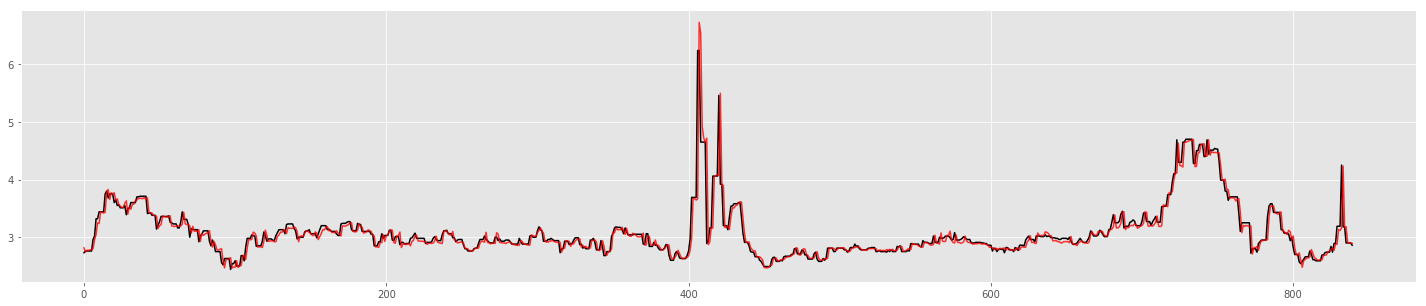

In [243]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([200, 400])
#axs.set_ylim([2.0, 4.0])
plt.show()

In [56]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions2 = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,15)))
    yhat = output[0]
    predictions2.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions2)
error = mean_squared_error(y_test, predictions2)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.03445


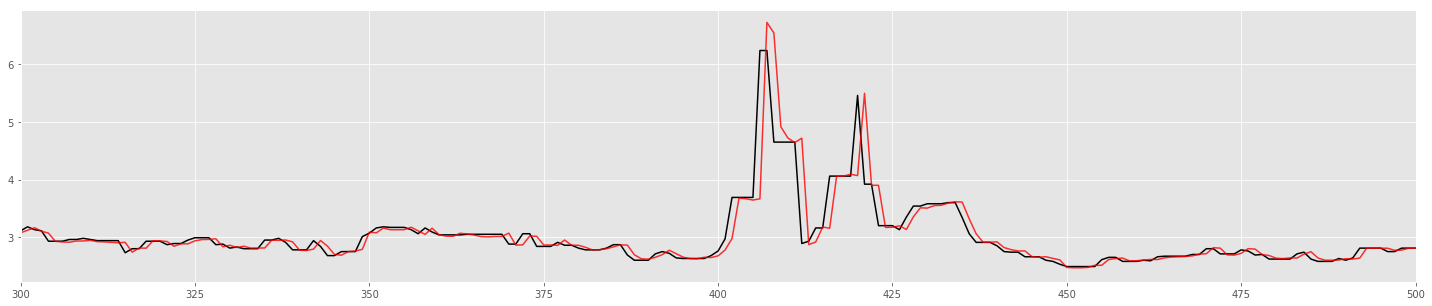

In [246]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
axs.set_xlim([300, 500])
#axs.set_ylim([2.0, 4.0])
plt.show()

In [189]:
test = np.array([0]+[(b - a)  for a, b in zip(y[::1], y[1::1])])
len(test), type(test)

(3357, numpy.ndarray)

In [230]:
no_back_df = ['Temp', 'Storage BCFE', 'Reserves BCFE','Consumption MMCF','DOY', 'DOW', 'MOY', 'WOY','Production MMCF'] #,'five_back', 'six_back', 

In [231]:
nb_df = df[no_back_df]

In [232]:
nb_df.head()

,Temp,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,DOW,MOY,WOY,Production MMCF
0,26.0317,3117.0,255035.0,1666520.0,1,4,1,53,2197157.0
1,24.2249,3117.0,255035.0,1666520.0,2,5,1,53,2197157.0
2,23.5537,3117.0,255035.0,1666520.0,3,6,1,53,2197157.0
3,23.2831,3117.0,255035.0,1666520.0,4,0,1,1,2197157.0
4,24.5469,3117.0,255035.0,1666520.0,5,1,1,1,2197157.0


In [233]:
X = nb_df.values

In [234]:
X[0]

array([2.603170e+01, 3.117000e+03, 2.550350e+05, 1.666520e+06,
       1.000000e+00, 4.000000e+00, 1.000000e+00, 5.300000e+01,
       2.197157e+06])

In [235]:
size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)], y[0:size], y[size:len(y)]

In [236]:
model = RandomForestRegressor()
depth_param = np.arange(1, 12, 1)
num_samples_param = np.arange(5,95,10)
n_trees = np.arange(1,70, 10)
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90], #, 100, 110
    'max_features': [2, 3, 4, 5, 9],
    'min_samples_leaf': [3, 4, 5, 10], #, 50, 90
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200] #, 300, 1000, 2000
}
clf = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
clf.fit(X_train,y_train)
print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

Accuracy score: -1.02


In [237]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [240]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions2 = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,9)))
    yhat = output[0]
    predictions2.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions2)
error = mean_squared_error(y_test, predictions2)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.41234


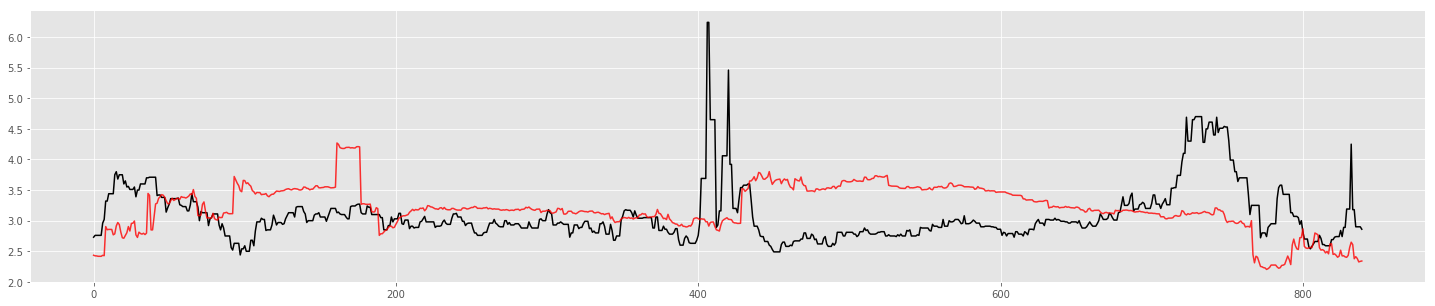

In [242]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions2, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

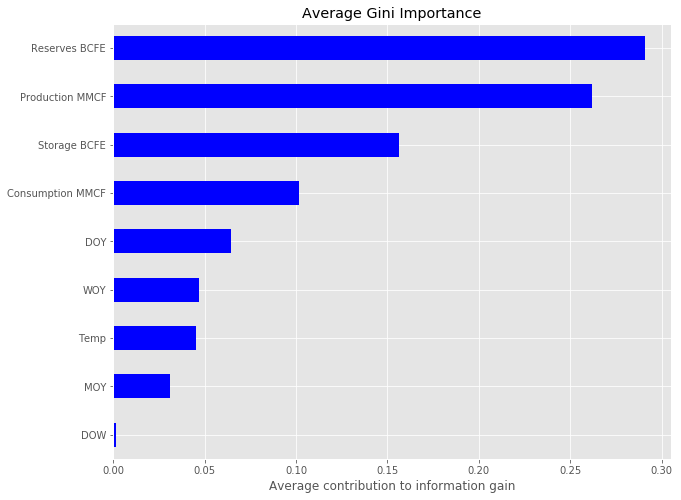

In [247]:
# Plot the feature importance
feat_scores = pd.Series(rfr.feature_importances_,
                           index=nb_df.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');